<a href="https://colab.research.google.com/github/Ujwal-EVA/Assignment-7/blob/main/EVA3_Session_7_Batch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Dataset - Creating Train/Test Split

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 906kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Data Statistics - how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


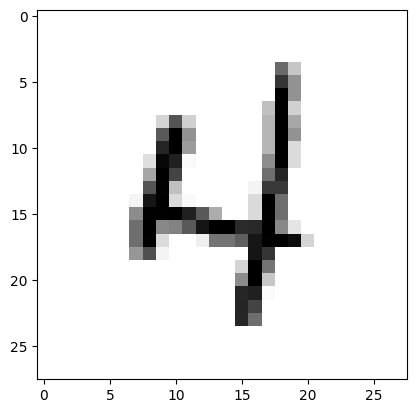

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


The Raw Model to Defined skeleton
1. Squeeze & Expand
2. Channel reduction (32--> 10)
3. Adding Max pooling
4. Adding Batch Normailisation
5. Adding Dropout


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Running Epoch & Plotting Results

EPOCH: 0


Loss=0.16171324253082275 Batch_id=468 Accuracy=93.10: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.1311, Accuracy: 9608/10000 (96.08%)

EPOCH: 1


Loss=0.04049165919423103 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0517, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.07606370002031326 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]



Test set: Average loss: 0.0439, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.019542796537280083 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]



Test set: Average loss: 0.0381, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.007342728320509195 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]



Test set: Average loss: 0.0452, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.022249186411499977 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0327, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.02197171188890934 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]



Test set: Average loss: 0.0439, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Loss=0.022476114332675934 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]



Test set: Average loss: 0.0313, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.008878983557224274 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]



Test set: Average loss: 0.0393, Accuracy: 9872/10000 (98.72%)

EPOCH: 9


Loss=0.0037358971312642097 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]



Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.07249678671360016 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0328, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.052374664694070816 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]



Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.012474894523620605 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]



Test set: Average loss: 0.0344, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.06687553972005844 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]



Test set: Average loss: 0.0277, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.012119862250983715 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

EPOCH: 15


Loss=0.017283592373132706 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0251, Accuracy: 9913/10000 (99.13%)

EPOCH: 16


Loss=0.0023808253463357687 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]



Test set: Average loss: 0.0321, Accuracy: 9902/10000 (99.02%)

EPOCH: 17


Loss=0.00825375784188509 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]



Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99.04%)

EPOCH: 18


Loss=0.003171101212501526 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]



Test set: Average loss: 0.0260, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.01539143268018961 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0285, Accuracy: 9900/10000 (99.00%)



Text(0.5, 1.0, 'Test Accuracy')

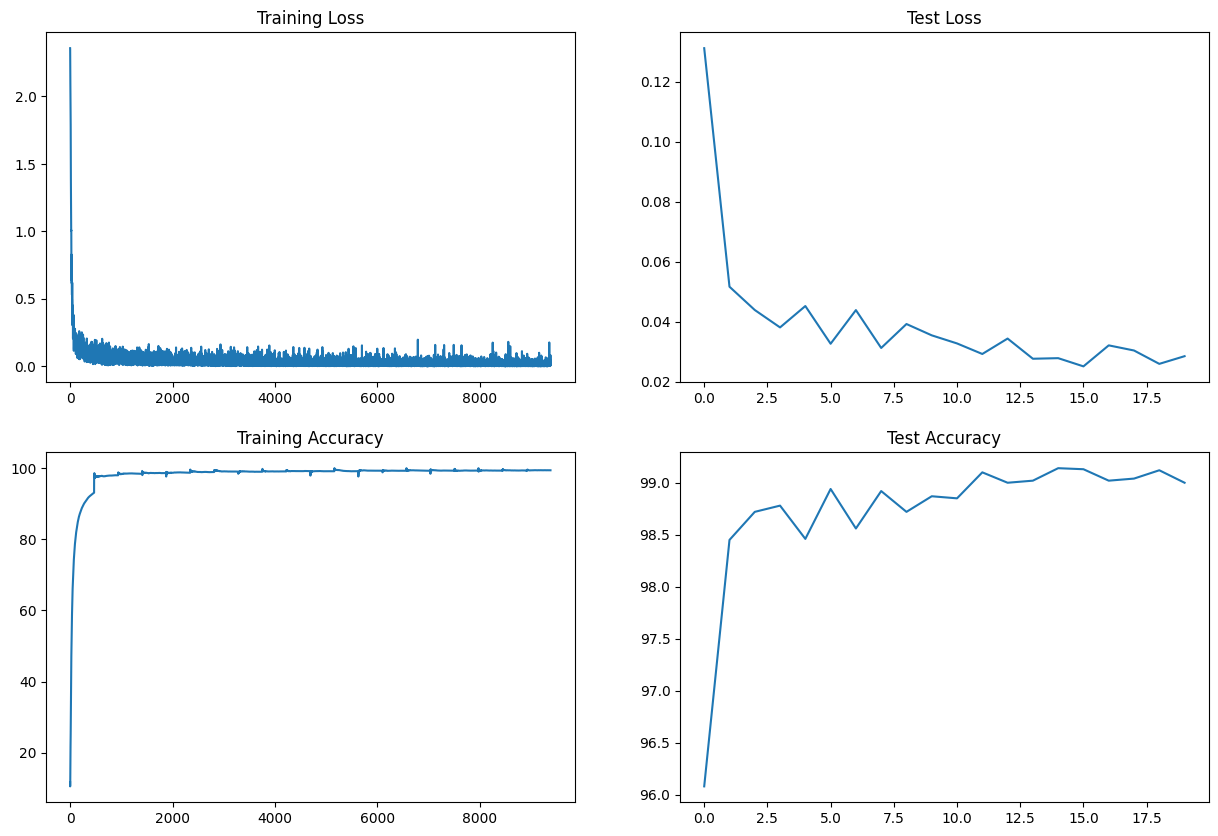

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

train_losses
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")